In [1]:
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)
# import climakitae as ck

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.backends.backend_pdf import PdfPages
import time
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx


print('done')

done


# What are we solving for? 
## Temperature
### 1. Number of days where maximum temperature exceeds the hottest 1% of days in observed data at a given grid cell (Peak_Heat)
### 2. Number of 4-day (or longer) events where maximum temperature exceeds the hottest 5% of all days in observed data at a given grid cell (ex_Heat)
### 3. Number of 4-day (or longer) events where minimum temperature exceeds the warmest 5% of all nights in observed data at a given grid cell (warm_nights)

## Precipitation:
### 1. Number of days where daily precipitation exceeds the highest 1% of days of rainfall in observed data at a given grid cell

### 2. Number of 3-day (or longer) events where daily precipitation exceeds the highest 5% of rainfall in observed data at a given grid cell


In [2]:
# Define the sets of variables
variables_units_list = [
    ("Maximum air temperature at 2m", "degF","Statistical","daily",[1.0,1.5,2.0]),
    ("Precipitation (total)", "inches","Statistical","daily",[1.0,1.5,2.0]),
]

# Initialize dataset variables
ds = None

# Loop through each set of variables and process them
for variables_units in variables_units_list:
    variable, unit, downscale, timescale, GWL = variables_units
    print(variable, unit, downscale, timescale, GWL)
    print(f"Processing variable: {variable}")
    start_time = time.time()
    tmp_ds = get_data(
        variable=variable,
        units=unit,
        downscaling_method=downscale,
        resolution="3 km",
        timescale=timescale,
        cached_area="Southern California Edison",
        approach="Warming Level",
        warming_level_window=15,
        warming_level=GWL
    )
    print(f"data retreived in {time.time() - start_time:.2f} seconds.")
    if ds is None:
        ds = tmp_ds
    else:
        ds = xr.combine_by_coords([ds, tmp_ds])
    del tmp_ds

print(ds)

proj_ds = ds.sel(warming_level=[1.5, 2.0])

Maximum air temperature at 2m degF Statistical daily [1.0, 1.5, 2.0]
Processing variable: Maximum air temperature at 2m
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.
data retreived in 152.34 seconds.
Precip

In [3]:
# Step 1 analyze historical data 

# using historical data --- need to figure out this method 
if 1 == 0: 
    variables_units_list = [
        ("Maximum air temperature at 2m", "degF","Statistical","daily"),
        ("Precipitation (total)", "inches","Statistical","daily"),
    ]

    # Initialize dataset variables
    hist_ds = None

    # Loop through each set of variables and process them
    for variables_units in variables_units_list:
        variable, unit, downscale, timescale = variables_units
        print(variable, unit, downscale, timescale, GWL)
        print(f"Processing variable: {variable}")
        start_time = time.time()
        tmp_ds = get_data(
            variable=variable,
            units=unit,
            downscaling_method=downscale,
            resolution="3 km",
            timescale=timescale,
            cached_area="Southern California Edison",
            scenario = "Historical Climate",
            time_slice = (2000,2020), # TBD 
        )
        print(f"data retreived in {time.time() - start_time:.2f} seconds.")
        if hist_ds is None:
            hist_ds = tmp_ds
        else:
            hist_ds = xr.combine_by_coords([hist_ds, tmp_ds])
        del tmp_ds
    
    
# method 2: temporary approach of using GWL 1.0
else:
    hist_ds = ds.sel(warming_level=1.0)

print(hist_ds)

<xarray.Dataset> Size: 379GB
Dimensions:                        (lat: 171, lon: 196, time_delta: 10950,
                                    simulation: 129)
Coordinates:
    warming_level                  float64 8B 1.0
  * lat                            (lat) float32 684B 33.17 33.2 ... 38.45 38.48
  * lon                            (lon) float32 784B -120.2 -120.2 ... -114.1
  * time_delta                     (time_delta) float64 88kB -5.475e+03 ... 5...
    spatial_ref                    int64 8B 0
    centered_year                  (simulation) int64 1kB 2014 2013 ... 2017
  * simulation                     (simulation) <U48 25kB 'LOCA2_ACCESS-CM2_r...
Data variables:
    Maximum air temperature at 2m  (time_delta, lat, lon, simulation) float32 189GB dask.array<chunksize=(17, 8, 16, 1), meta=np.ndarray>
    Precipitation (total)          (time_delta, lat, lon, simulation) float32 189GB dask.array<chunksize=(17, 8, 16, 1), meta=np.ndarray>


In [53]:
print(hist_ds.centered_year)

<xarray.DataArray 'centered_year' (simulation: 129)> Size: 1kB
array([2014, 2013, 2013, 2013, 2013, 2012, 2013, 2014, 2012, 2005, 2003,
       2009, 2006, 2009, 2002, 2003, 2004, 2007, 2005, 2013, 2014, 2012,
       2006, 2005, 1991, 2006, 1991, 2006, 1998, 1991, 1988, 1999, 1998,
       2007, 1977, 1988, 1999, 1998, 2007, 1988, 1999, 1998, 2007, 2004,
       2005, 2002, 2004, 2005, 2002, 2003, 2004, 2005, 2002, 2017, 2020,
       2019, 2008, 2008, 2005, 2012, 2012, 2011, 2011, 2012, 2016, 2011,
       2012, 2000, 1996, 1997, 2002, 1997, 2001, 2000, 1996, 1997, 2002,
       1997, 2006, 1995, 2002, 1994, 2000, 1996, 1997, 2002, 1997, 1994,
       1996, 1997, 1994, 1996, 1997, 1994, 1996, 2022, 2021, 2021, 2023,
       2025, 2022, 2020, 2022, 2021, 2019, 2022, 2009, 2000, 2008, 2009,
       2000, 2003, 2010, 2002, 2005, 2005, 2004, 2002, 2009, 2000, 2011,
       2011, 2012, 2014, 2015, 2007, 2010, 2016, 2017])
Coordinates:
    warming_level  float64 8B 1.0
    spatial_ref    int64 8B 0
 

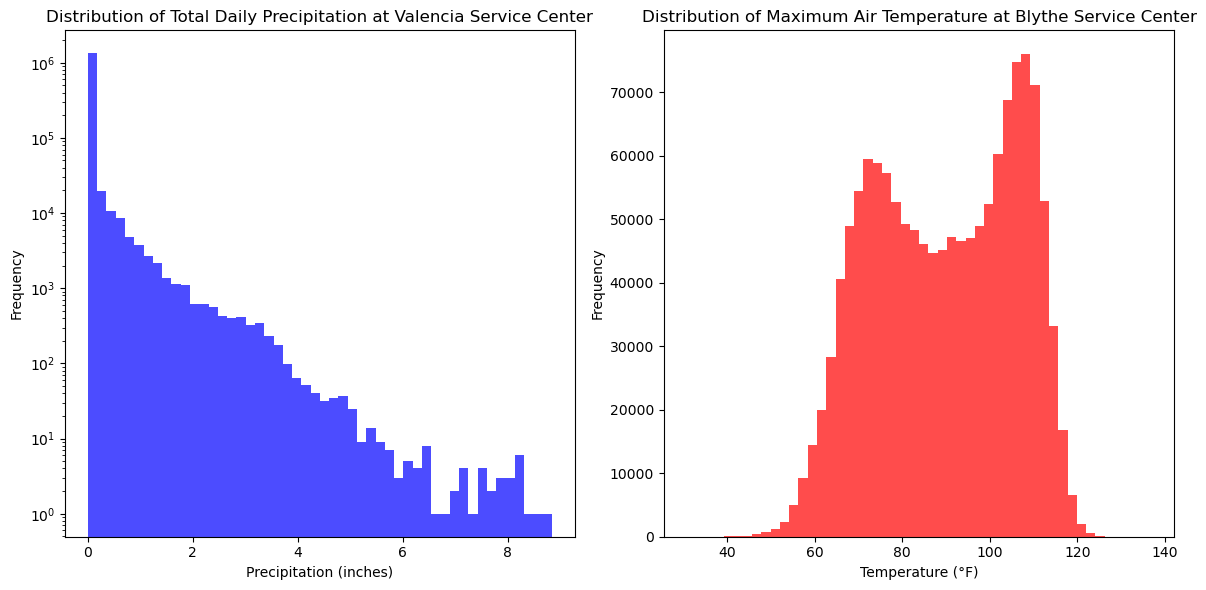

/opt/conda/envs/climakitae/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/opt/conda/envs/climakitae/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/opt/conda/envs/climakitae/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/opt/conda/envs/climakitae/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/opt/conda/envs/climakitae/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [4]:
BSC_lat = 33.609375
BSC_lon = -114.609375

VSC_lat = 34.421875
VSC_lon = -118.578125

# Extract data for the random lat and lon
precipitation_data = hist_ds['Precipitation (total)'].sel(lat=VSC_lat, lon=VSC_lon).values.flatten()
temperature_data = hist_ds['Maximum air temperature at 2m'].sel(lat=BSC_lat, lon=BSC_lon).values.flatten()

# analyze historical data 
# Plot the distribution of total precipitation and maximum air temperature
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(precipitation_data, bins=50, color='blue', alpha=0.7)
plt.title(f'Distribution of Total Daily Precipitation at Valencia Service Center')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')
# plt.xlim(0.001, 10)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(temperature_data, bins=50, color='red', alpha=0.7)
plt.title(f'Distribution of Maximum Air Temperature at Blythe Service Center')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('distribution.png')
plt.show()


In [ ]:
print('done')

In [ ]:
# Find the 1% highest and 5% highest values in the time_delta dimension for each lat, lon, and simulation
def find_percentile_values(data_array, percentile):
    return data_array.quantile(percentile / 100.0, dim='time_delta')

highest_1_percent_precipitation = find_percentile_values(hist_ds['Precipitation (total)'], 99)
highest_5_percent_precipitation = find_percentile_values(hist_ds['Precipitation (total)'], 95)
highest_1_percent_temperature = find_percentile_values(hist_ds['Maximum air temperature at 2m'], 99)
highest_5_percent_temperature = find_percentile_values(hist_ds['Maximum air temperature at 2m'], 95)
start_time = time.time()
print(highest_1_percent_precipitation)
highest_1_percent_temperature.load()
highest_5_percent_temperature.load()

highest_1_percent_precipitation.load()
highest_5_percent_precipitation.load()
print(f"Percentiles for {variable} calculated in {time.time() - start_time:.2f} seconds.")

<xarray.DataArray 'Precipitation (total)' (lat: 171, lon: 196, simulation: 129)> Size: 35MB
dask.array<getitem, shape=(171, 196, 129), dtype=float64, chunksize=(36, 40, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float32 684B 33.17 33.2 33.23 ... 38.42 38.45 38.48
  * lon            (lon) float32 784B -120.2 -120.2 -120.2 ... -114.2 -114.1
    centered_year  (simulation) int64 1kB 2014 2013 2013 2013 ... 2010 2016 2017
  * simulation     (simulation) <U48 25kB 'LOCA2_ACCESS-CM2_r1i1p1f1_historic...
    quantile       float64 8B 0.99
Attributes:
    variable_id:           pr
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 inches
    data_type:             Gridded
    resolution:            3 km
    frequency:             daily
    location_subset:       ['Southern California Edison']
    approach:              Warming Level
    downscaling_method:    Statistical
    warming_level_window:  +/- 15 years fro

In [26]:
print('done')

done


In [27]:
highest_1_percent_temperature.to_netcdf('highest_1_percent_temperature.nc')
highest_5_percent_temperature.to_netcdf('highest_5_percent_temperature.nc')

highest_1_percent_precipitation.to_netcdf('highest_1_percent_precipitation.nc')
highest_5_percent_precipitation.to_netcdf('highest_5_percent_precipitation.nc')

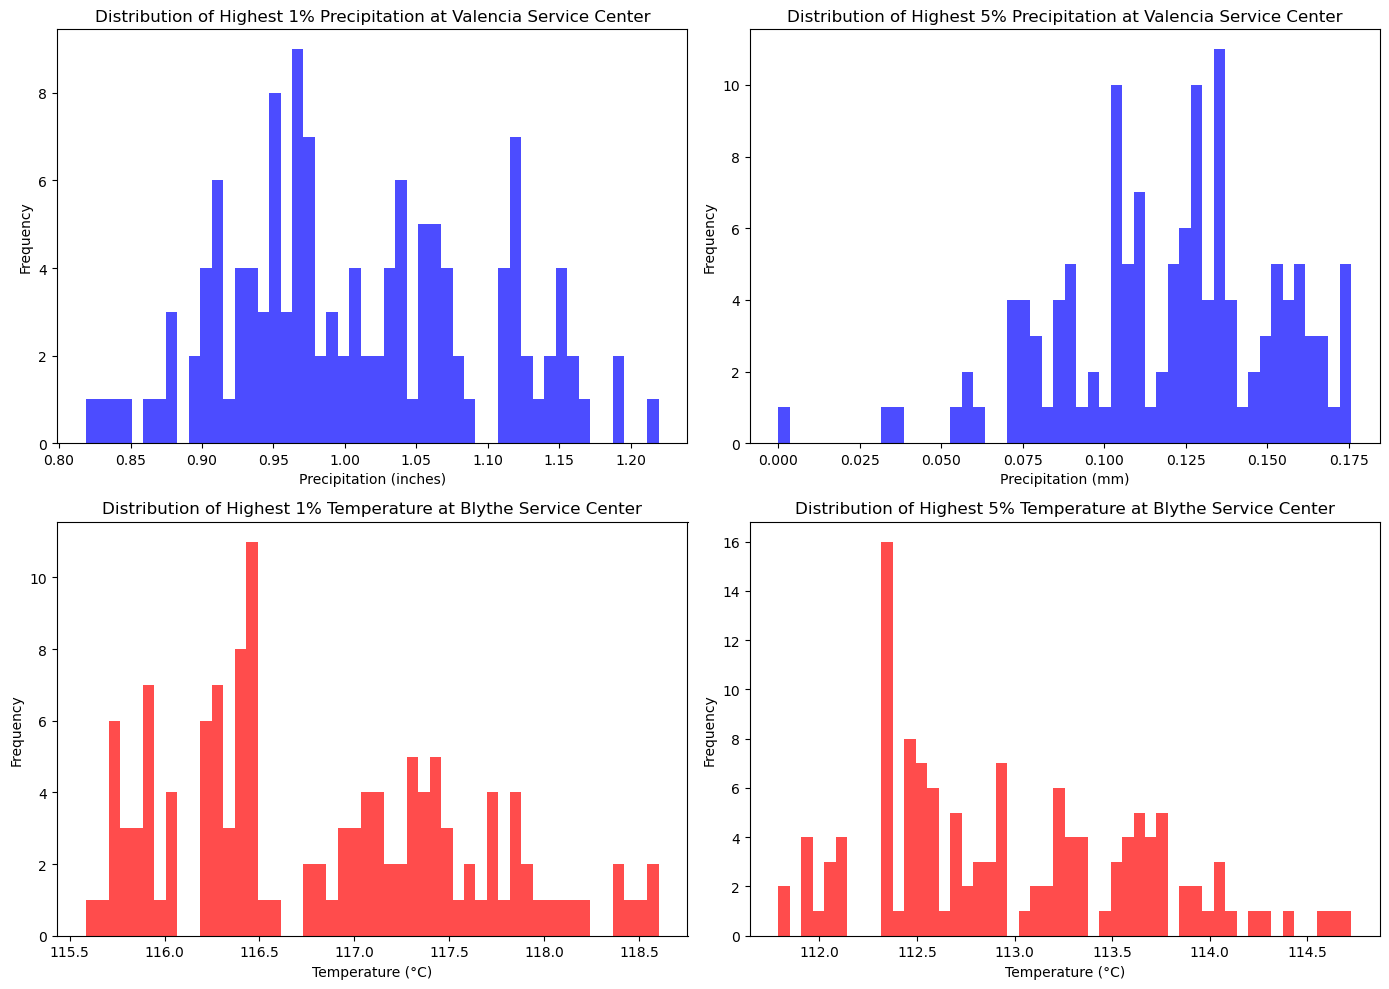

In [10]:
BSC_lat = 33.609375
BSC_lon = -114.609375

VSC_lat = 34.421875
VSC_lon = -118.578125

# Plot the distribution for the highest 1% and highest 5% along the "simulation" dimension using the same lat and lon
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].hist(highest_1_percent_precipitation.sel(lat=VSC_lat, lon=VSC_lon).values.flatten(), bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title(f'Distribution of Highest 1% Precipitation at Valencia Service Center')
axs[0, 0].set_xlabel('Precipitation (inches)')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(highest_5_percent_precipitation.sel(lat=VSC_lat, lon=VSC_lon).values.flatten(), bins=50, color='blue', alpha=0.7)
axs[0, 1].set_title(f'Distribution of Highest 5% Precipitation at Valencia Service Center')
axs[0, 1].set_xlabel('Precipitation (mm)')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(highest_1_percent_temperature.sel(lat=BSC_lat, lon=BSC_lon).values.flatten(), bins=50, color='red', alpha=0.7)
axs[1, 0].set_title(f'Distribution of Highest 1% Temperature at Blythe Service Center')
axs[1, 0].set_xlabel('Temperature (°C)')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(highest_5_percent_temperature.sel(lat=BSC_lat, lon=BSC_lon).values.flatten(), bins=50, color='red', alpha=0.7)
axs[1, 1].set_title(f'Distribution of Highest 5% Temperature at Blythe Service Center')
axs[1, 1].set_xlabel('Temperature (°C)')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('percentile_distribution.png')
plt.show()


In [28]:
print('done')

done


In [30]:
percentiles = [10, 50, 90]

highest_1_percent_precipitation_percentile_values = {p: highest_1_percent_precipitation.quantile(p / 100.0, dim='simulation', skipna=True) 
                                                     for p in percentiles}
highest_5_percent_precipitation_percentile_values = {p: highest_5_percent_precipitation.quantile(p / 100.0, dim='simulation', skipna=True) 
                                                     for p in percentiles}

highest_1_percent_temperature_percentile_values = {p: highest_1_percent_temperature.quantile(p / 100.0, dim='simulation', skipna=True) 
                                                     for p in percentiles}
highest_5_percent_temperature_percentile_values = {p: highest_5_percent_temperature.quantile(p / 100.0, dim='simulation', skipna=True) 
                                                     for p in percentiles}

In [31]:
print(highest_5_percent_temperature_percentile_values[50])

<xarray.DataArray 'Maximum air temperature at 2m' (lat: 171, lon: 196)> Size: 134kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 684B 33.17 33.2 33.23 33.27 ... 38.42 38.45 38.48
  * lon       (lon) float32 784B -120.2 -120.2 -120.2 ... -114.2 -114.2 -114.1
    quantile  float64 8B 0.5
Attributes:
    variable_id:           tasmax
    extended_description:  The maximum daily air temperature at 2m above the ...
    units:                 degF
    data_type:             Gridded
    resolution:            3 km
    frequency:             daily
    location_subset:       ['Southern California Edison']
    approach:              Warming Level
    downscaling_method:    Statistical
    warming_level_window:  +

Text(945.087080660949, 0.5, 'Latitude')

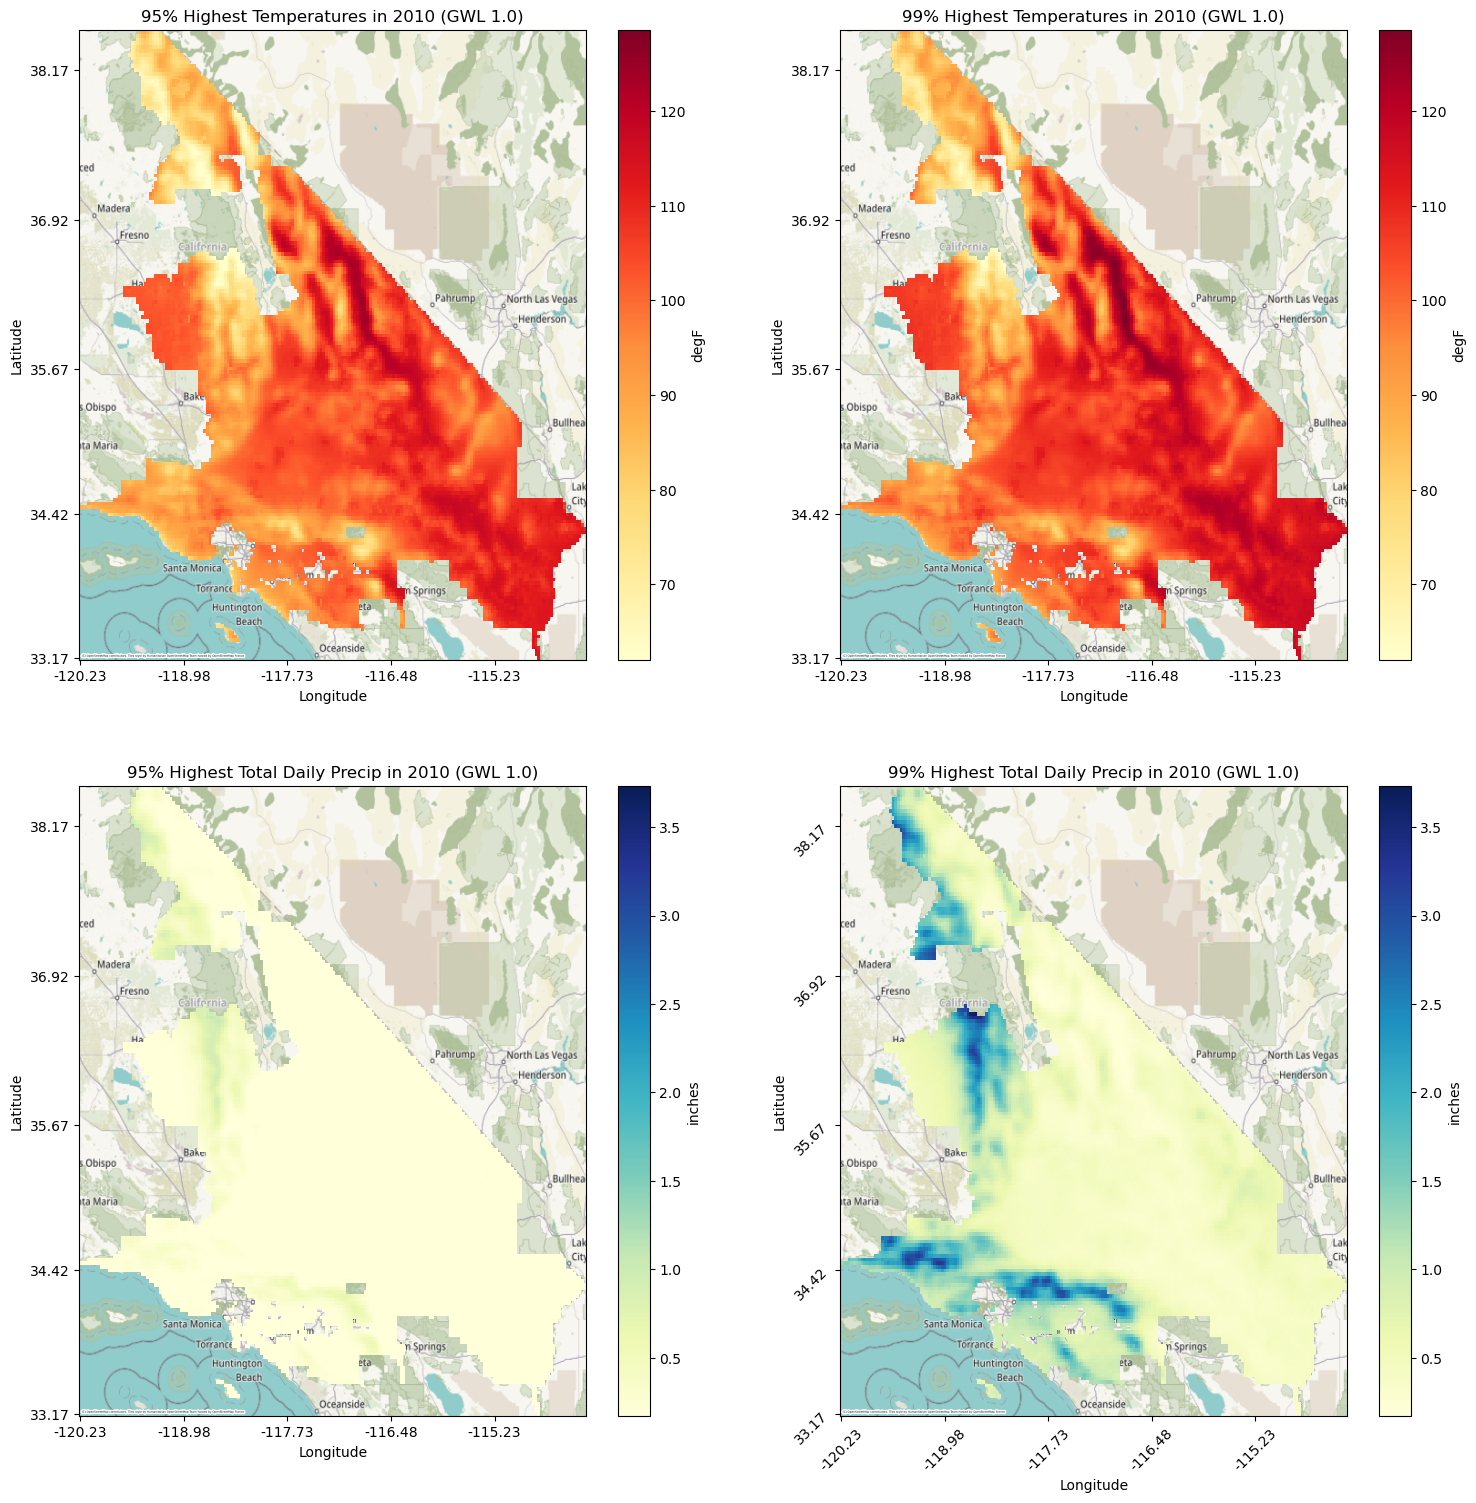

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
lon2d, lat2d = np.meshgrid(highest_5_percent_temperature_percentile_values[50].lon, highest_5_percent_temperature_percentile_values[50].lat)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x_web, y_web = transformer.transform(lon2d, lat2d)
transformer_back = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
lon_back, lat_back = transformer_back.transform(x_web, y_web) 


temp_min = highest_1_percent_temperature_percentile_values[50].min()
temp_max = highest_1_percent_temperature_percentile_values[50].max()
ax = axs[0, 0]
mesh = ax.pcolormesh(x_web, y_web, highest_5_percent_temperature_percentile_values[50], cmap='YlOrRd',vmin=temp_min, vmax=temp_max)
cx.add_basemap(ax, crs="EPSG:3857", attribution_size=2)
ax.set_title(f'95% Highest Temperatures in 2010 (GWL 1.0)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.colorbar(mesh, ax=ax, label=highest_5_percent_temperature_percentile_values[50].attrs['units'])
# Set the tick labels and reduce the number of ticks by half
ax.set_xticks(x_web[0, ::40])  # Adjust the step size to half
ax.set_xticklabels(np.round(lon_back[0, ::40], 2))
ax.set_yticks(y_web[::40, 0])  # Adjust the step size to half
ax.set_yticklabels(np.round(lat_back[::40, 0], 2))
# Rotate the tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)
# Label the axes
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax = axs[0, 1]
mesh = ax.pcolormesh(x_web, y_web, highest_1_percent_temperature_percentile_values[50], cmap='YlOrRd',vmin=temp_min, vmax=temp_max)
cx.add_basemap(ax, crs="EPSG:3857", attribution_size=2)
ax.set_title(f'99% Highest Temperatures in 2010 (GWL 1.0)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.colorbar(mesh, ax=ax, label=highest_5_percent_temperature_percentile_values[50].attrs['units'])
# Set the tick labels and reduce the number of ticks by half
ax.set_xticks(x_web[0, ::40])  # Adjust the step size to half
ax.set_xticklabels(np.round(lon_back[0, ::40], 2))
ax.set_yticks(y_web[::40, 0])  # Adjust the step size to half
ax.set_yticklabels(np.round(lat_back[::40, 0], 2))
# Rotate the tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)
# Label the axes
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## PRECIP
prec_min = highest_1_percent_precipitation_percentile_values[50].min()
prec_max = highest_1_percent_precipitation_percentile_values[50].max()
ax = axs[1, 0]
mesh = ax.pcolormesh(x_web, y_web, highest_5_percent_precipitation_percentile_values[50], cmap='YlGnBu',vmin=prec_min, vmax=prec_max)
cx.add_basemap(ax, crs="EPSG:3857", attribution_size=2)
ax.set_title(f'95% Highest Total Daily Precip in 2010 (GWL 1.0)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.colorbar(mesh, ax=ax, label=highest_5_percent_precipitation_percentile_values[50].attrs['units'])
# Set the tick labels and reduce the number of ticks by half
ax.set_xticks(x_web[0, ::40])  # Adjust the step size to half
ax.set_xticklabels(np.round(lon_back[0, ::40], 2))
ax.set_yticks(y_web[::40, 0])  # Adjust the step size to half
ax.set_yticklabels(np.round(lat_back[::40, 0], 2))
# Rotate the tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)
# Label the axes
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax = axs[1, 1]
mesh = ax.pcolormesh(x_web, y_web, highest_1_percent_precipitation_percentile_values[50], cmap='YlGnBu',vmin=prec_min, vmax=prec_max)
cx.add_basemap(ax, crs="EPSG:3857", attribution_size=2)
ax.set_title(f'99% Highest Total Daily Precip in 2010 (GWL 1.0)')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.colorbar(mesh, ax=ax, label=highest_1_percent_precipitation_percentile_values[50].attrs['units'])
# Set the tick labels and reduce the number of ticks by half
ax.set_xticks(x_web[0, ::40])  # Adjust the step size to half
ax.set_xticklabels(np.round(lon_back[0, ::40], 2))
ax.set_yticks(y_web[::40, 0])  # Adjust the step size to half
ax.set_yticklabels(np.round(lat_back[::40, 0], 2))
# Rotate the tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)
# Label the axes
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [46]:
BSC_lat = 33.609375
BSC_lon = -114.609375

print(f'95% Temperature at Blythe Service Center:', highest_5_percent_temperature_percentile_values[50].sel(lat=BSC_lat, lon=BSC_lon).values,'degF')

print(f'99% Temperature at Blythe Service Center:', highest_1_percent_temperature_percentile_values[50].sel(lat=BSC_lat, lon=BSC_lon).values, 'degF')

95% Temperature at Blythe Service Center: 112.87411 degF
99% Temperature at Blythe Service Center: 116.770935 degF


In [51]:
VSC_lat = 33.328125
VSC_lon = -118.328125

print(f'95% Precipitation at Catalina Service Center:', highest_5_percent_precipitation_percentile_values[50].sel(lat=VSC_lat, lon=VSC_lon).values,'inches')

print(f'99% Precipitation at Catalina Service Center:', highest_1_percent_precipitation_percentile_values[50].sel(lat=VSC_lat, lon=VSC_lon).values,'inches')

95% Precipitation at Catalina Service Center: 0.080445096 inches
99% Precipitation at Catalina Service Center: 0.8205085 inches
